<a href="https://colab.research.google.com/github/MaryamNourii/EmotionDetection/blob/EN/ED_Bert_BalancedEDds_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

In [ ]:
!pip install tensorflow_addons

In [ ]:
import nltk
nltk.download('punkt')

In [19]:
from transformers import AutoConfig, AutoTokenizer, TFAutoModel,TFBertForSequenceClassification


from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import regex as re


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers import TFBertModel, BertTokenizerFast, BertConfig

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow_addons.optimizers import AdamW

In [5]:
MODEL_NAME_OR_PATH = 'bert-base-uncased'

In [6]:
train_data = pd.read_csv('data_train.csv', sep=',')

test_data = pd.read_csv('data_test.csv', sep=',')

In [7]:
class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']

train_data['label'] = train_data['Emotion'].map({'joy':0, 'sadness':1, 'anger':2, 'neutral':3, 'fear':4})
train_data = train_data.rename(columns={"Text": "text"})

test_data['label'] = test_data['Emotion'].map({'joy':0, 'sadness':1, 'anger':2, 'neutral':3, 'fear':4})
test_data = test_data.rename(columns={"Text": "text"})

print('size of training set: %s' % (len(train_data)))
print('size of test set: %s' % (len(test_data)))


size of training set: 7934
size of test set: 3393


In [8]:
train_data[train_data['text'].isnull()]

,Emotion,text,label


In [9]:
test_data[test_data['text'].isnull()]

,Emotion,text,label


In [10]:
train_x = train_data['text']
train_y = train_data['label']

test_x = test_data['text']
test_y = test_data['label']


In [11]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\W|\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    # stem_data /= stem_data + ' ' + [porter.stem(word) for word in data]

    new_words = ''
    for word in data:
      word = porter.stem(word)
      new_words = new_words + ' ' + word
            
    return new_words

In [12]:
train_x = train_x.apply(lambda t: preprocess_and_tokenize(t))
test_x = test_x.apply(lambda t: preprocess_and_tokenize(t))

In [14]:
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size=0.1)

In [15]:
max_length = train_x.apply(lambda x: len(x.split())).max()
max_length  

231

In [20]:
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = MODEL_NAME_OR_PATH, config = config)
transformer_model = TFAutoModel.from_pretrained(MODEL_NAME_OR_PATH, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
token_ids = Input(shape=(max_length,), name='token_ids', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert_model = transformer_model(inputs)[1]
pooled_output = Dropout(config.hidden_dropout_prob, name='pooled_output')(bert_model, training=False)

emotion = Dense(units=7, activation="sigmoid", kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
outputs = emotion

model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel')
model.layers[1].trainable = False

In [23]:
model.summary() 

Model: "BERT_MultiLabel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 231)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 231)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 231,                                 

In [24]:
train_token = tokenizer(
    text = train_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

val_token = tokenizer(
    text = val_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

test_token = tokenizer(
    text = test_x.to_list(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = 'max_length', 
    return_tensors = 'tf',
    return_token_type_ids = True,
    return_attention_mask = True,
    verbose = True)

In [25]:
train = {'input_ids': train_token['input_ids'], 'attention_mask': train_token['attention_mask'],'token_ids': train_token['token_type_ids']}
val = {'input_ids': val_token['input_ids'], 'attention_mask': val_token['attention_mask'],'token_ids': val_token['token_type_ids']}
test = {'input_ids': test_token['input_ids'], 'attention_mask': test_token['attention_mask'],'token_ids': test_token['token_type_ids']}

In [26]:
train_tensor = tf.data.Dataset.from_tensor_slices((train, train_y)).shuffle(len(train)).batch(16)
val_tensor = tf.data.Dataset.from_tensor_slices((val, val_y)).shuffle(len(val)).batch(16)
test_tensor = tf.data.Dataset.from_tensor_slices((test, test_y)).shuffle(len(test)).batch(16)

In [22]:
optimizer = Adam(
    learning_rate=5.e-05,
    )

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])


log_dir='tb_bert'
model_save_path='bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',mode='min'
                                                ,save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history = model.fit(train_tensor, 
                    epochs=4, 
                    validation_data=val_tensor,
                    callbacks=callbacks, shuffle=True)

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


447/447 [==============================] - 213s 428ms/step - loss: 0.9499 - accuracy: 0.6415 - val_loss: 0.6920 - val_accuracy: 0.7531
Epoch 2/4
447/447 [==============================] - 188s 420ms/step - loss: 0.4852 - accuracy: 0.8361 - val_loss: 0.6887 - val_accuracy: 0.7670
Epoch 3/4
447/447 [==============================] - 186s 415ms/step - loss: 0.2854 - accuracy: 0.9139 - val_loss: 0.8090 - val_accuracy: 0.7607
Epoch 4/4
447/447 [==============================] - 186s 416ms/step - loss: 0.1917 - accuracy: 0.9429 - val_loss: 0.9143 - val_accuracy: 0.7834


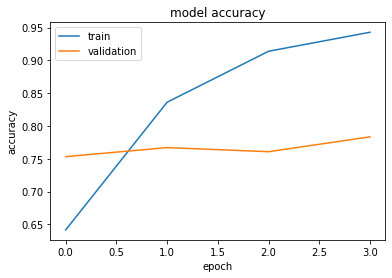

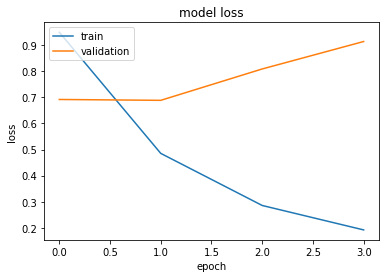

In [29]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
pred_y = model.predict(test_tensor)
predictions = np.argmax(pred_y, axis=1)

213/213 [==============================] - 33s 145ms/step


In [25]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_y, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, predictions, average='micro') * 100))

Accuracy: 27.85%

F1 Score: 27.85


In [32]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [27]:
predictions = np.argmax(pred_y, axis=1)

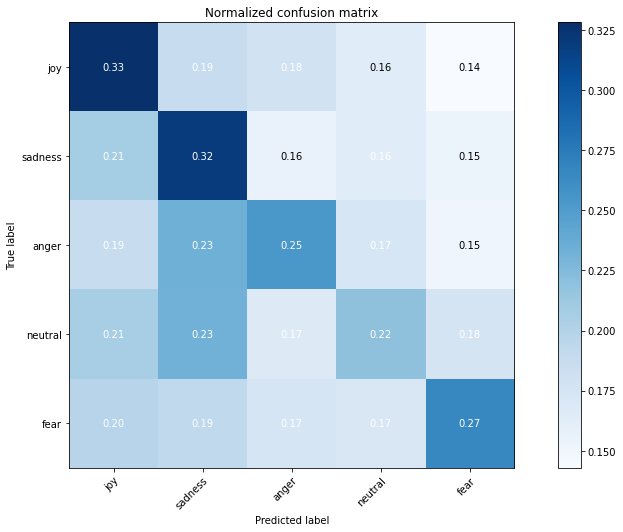

In [28]:
plot_confusion_matrix(test_y, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [27]:
optimizer = AdamW(lr=6e-6,weight_decay=1e-07)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])


log_dir='tb_bert'
model_save_path='bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',mode='min'
                                                ,save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history = model.fit(train_tensor, 
                    epochs=4, 
                    validation_data=val_tensor,
                    callbacks=callbacks, shuffle=True)

Epoch 1/4


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['token_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


447/447 [==============================] - 376s 802ms/step - loss: 1.3344 - accuracy: 0.4882 - val_loss: 0.9535 - val_accuracy: 0.6763
Epoch 2/4
447/447 [==============================] - 354s 792ms/step - loss: 0.7654 - accuracy: 0.7417 - val_loss: 0.7426 - val_accuracy: 0.7418
Epoch 3/4
447/447 [==============================] - 354s 792ms/step - loss: 0.5348 - accuracy: 0.8296 - val_loss: 0.7319 - val_accuracy: 0.7506
Epoch 4/4
447/447 [==============================] - 352s 788ms/step - loss: 0.3974 - accuracy: 0.8775 - val_loss: 0.7782 - val_accuracy: 0.7582


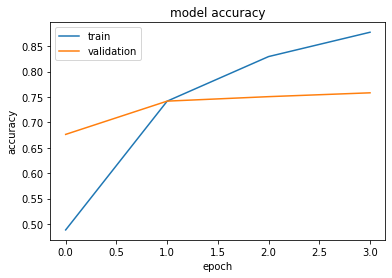

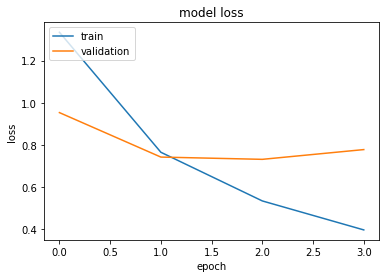

In [28]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
pred_y = model.predict(test_tensor)
predictions = np.argmax(pred_y, axis=1)

213/213 [==============================] - 62s 270ms/step


In [30]:
print("Accuracy: {:.2f}%".format(accuracy_score(test_y, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_y, predictions, average='micro') * 100))

Accuracy: 29.35%

F1 Score: 29.35


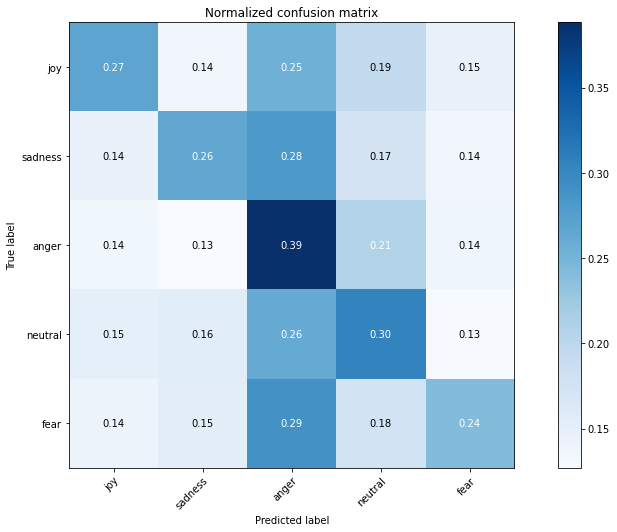

In [33]:
predictions = np.argmax(pred_y, axis=1)
plot_confusion_matrix(test_y, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()